# Regression Duplication

Checking that I get the same results as the paper.

In equation **S3** the authors give the probability that an individual $i$ startels given that individual $j$ has startled as
$$
P(s_i | s_j) = \dfrac{1}{1+e^{-\beta_1-\beta_2 LMD - \beta_3 RAA}}
$$

- *LMD* is the log of the metric distance between the two fish
- *RAA* is the ranked angular area of fish $j$ (compared to other fish) on the retina of fish $i$.

Authors fit a logistic regression model to the entire dataset and find coefficients $beta_n$ $0.06449$, $−3.20552$, and $−0.08016$.

In [64]:
import pandas as pd
import numpy as np

# Read the CSV into dataframe
csv_path = "realdata/first_responders_srk1.csv"
df = pd.read_csv(csv_path)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14490 entries, 0 to 14489
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Trial             14490 non-null  object 
 1   Event_raw         14490 non-null  int64  
 2   Event_trial       14490 non-null  int64  
 3   Response          14490 non-null  int64  
 4   Resp_Int          14490 non-null  float64
 5   Initiator         14490 non-null  float64
 6   Log_Init          14490 non-null  float64
 7   When              14490 non-null  object 
 8   Class             14490 non-null  object 
 9   Dist_metric       14490 non-null  float64
 10  Log_dist_metric   14490 non-null  float64
 11  Dist_topological  14490 non-null  int64  
 12  Ang_area          14490 non-null  float64
 13  Rank_area         14490 non-null  int64  
 14  Loom              14490 non-null  float64
 15  Log_loom          14490 non-null  float64
 16  Ang_pos           14490 non-null  float6

This code block - written by Claude - attempts to recreate the coefficients the authors find in the last paragraph of Section 6.1.

There is a difference in the author's values compared to what I could find. I think that's due to the simplification of omitting the higher order terms in equation **S7**. But they say that for small cascades they are very small, so this works out.

In [65]:
# Fit the logistic regression model, to verify author's findings
# Targeting the PARAGRAPH values for first exposure (combining Before+After)
# Target: Intercept=0.06449, Log_dist_metric=-3.20552, Rank_area=-0.08016

import statsmodels.api as sm

print("=" * 80)
print("TARGETING PARAGRAPH VALUES FOR FIRST EXPOSURE")
print("=" * 80)
print("\nAuthors' reported coefficients (combining Before+After):")
print("  Intercept:        0.06449")
print("  Log_dist_metric: -3.20552")
print("  Rank_area:       -0.08016")

# Try different data filters to match author's approach
print("\n" + "=" * 80)
print("ATTEMPT 1: All data (Before + After, Schreck + Water)")
print("=" * 80)

X1 = df[["Log_dist_metric", "Rank_area"]]
y1 = df["Response"]
X1_const = sm.add_constant(X1)

logit1 = sm.Logit(y1, X1_const)
result1 = logit1.fit(disp=0)

print(f"Observations: {len(y1)}, Responses: {y1.sum()}")
print(f"  Intercept:        {result1.params['const']:>10.5f}")
print(f"  Log_dist_metric:  {result1.params['Log_dist_metric']:>10.5f}")
print(f"  Rank_area:        {result1.params['Rank_area']:>10.5f}")

# Try filtering for Schreckstoff only
print("\n" + "=" * 80)
print("ATTEMPT 2: Schreckstoff only (Before + After, Class=Schreck)")
print("=" * 80)

df_schreck = df[df["Class"] == "Schreck"].copy()
X2 = df_schreck[["Log_dist_metric", "Rank_area"]]
y2 = df_schreck["Response"]
X2_const = sm.add_constant(X2)

logit2 = sm.Logit(y2, X2_const)
result2 = logit2.fit(disp=0)

print(f"Observations: {len(y2)}, Responses: {y2.sum()}")
print(f"  Intercept:        {result2.params['const']:>10.5f}")
print(f"  Log_dist_metric:  {result2.params['Log_dist_metric']:>10.5f}")
print(f"  Rank_area:        {result2.params['Rank_area']:>10.5f}")

# Try Water control only
print("\n" + "=" * 80)
print("ATTEMPT 3: Water control only (Before + After, Class=Water)")
print("=" * 80)

df_water = df[df["Class"] == "Water"].copy()
X3 = df_water[["Log_dist_metric", "Rank_area"]]
y3 = df_water["Response"]
X3_const = sm.add_constant(X3)

logit3 = sm.Logit(y3, X3_const)
result3 = logit3.fit(disp=0)

print(f"Observations: {len(y3)}, Responses: {y3.sum()}")
print(f"  Intercept:        {result3.params['const']:>10.5f}")
print(f"  Log_dist_metric:  {result3.params['Log_dist_metric']:>10.5f}")
print(f"  Rank_area:        {result3.params['Rank_area']:>10.5f}")

# Try only After Schreckstoff
print("\n" + "=" * 80)
print("ATTEMPT 4: After Schreckstoff only (When=After, Class=Schreck)")
print("=" * 80)

df_after_schreck = df[(df["When"] == "After") & (df["Class"] == "Schreck")].copy()
X4 = df_after_schreck[["Log_dist_metric", "Rank_area"]]
y4 = df_after_schreck["Response"]
X4_const = sm.add_constant(X4)

logit4 = sm.Logit(y4, X4_const)
result4 = logit4.fit(disp=0)

print(f"Observations: {len(y4)}, Responses: {y4.sum()}")
print(f"  Intercept:        {result4.params['const']:>10.5f}")
print(f"  Log_dist_metric:  {result4.params['Log_dist_metric']:>10.5f}")
print(f"  Rank_area:        {result4.params['Rank_area']:>10.5f}")

# Try Before+After Water (baseline)
print("\n" + "=" * 80)
print("ATTEMPT 5: Before+After Water (baseline control)")
print("=" * 80)

df_water_both = df[df["Class"] == "Water"].copy()
X5 = df_water_both[["Log_dist_metric", "Rank_area"]]
y5 = df_water_both["Response"]
X5_const = sm.add_constant(X5)

logit5 = sm.Logit(y5, X5_const)
result5 = logit5.fit(disp=0)

print(f"Observations: {len(y5)}, Responses: {y5.sum()}")
print(f"  Intercept:        {result5.params['const']:>10.5f}")
print(f"  Log_dist_metric:  {result5.params['Log_dist_metric']:>10.5f}")
print(f"  Rank_area:        {result5.params['Rank_area']:>10.5f}")

# Summary comparison
print("\n" + "=" * 80)
print("SUMMARY COMPARISON")
print("=" * 80)

comparison = pd.DataFrame(
    {
        "Data Filter": [
            "Authors (Paragraph)",
            "All data",
            "Schreck only",
            "Water only",
            "After+Schreck",
            "Water (Before+After)",
        ],
        "Intercept": [
            0.06449,
            result1.params["const"],
            result2.params["const"],
            result3.params["const"],
            result4.params["const"],
            result5.params["const"],
        ],
        "Log_dist_metric": [
            -3.20552,
            result1.params["Log_dist_metric"],
            result2.params["Log_dist_metric"],
            result3.params["Log_dist_metric"],
            result4.params["Log_dist_metric"],
            result5.params["Log_dist_metric"],
        ],
        "Rank_area": [
            -0.08016,
            result1.params["Rank_area"],
            result2.params["Rank_area"],
            result3.params["Rank_area"],
            result4.params["Rank_area"],
            result5.params["Rank_area"],
        ],
    }
)

print("\n", comparison.to_string(index=False))

# Find closest match
diffs = []
for i in range(1, 6):
    diff = (
        abs(comparison.iloc[i]["Intercept"] - 0.06449)
        + abs(comparison.iloc[i]["Log_dist_metric"] - (-3.20552))
        + abs(comparison.iloc[i]["Rank_area"] - (-0.08016))
    )
    diffs.append(diff)

best_idx = diffs.index(min(diffs)) + 1
print(f"\n\nBest match: {comparison.iloc[best_idx]['Data Filter']}")
print(f"Total absolute difference: {min(diffs):.4f}")

TARGETING PARAGRAPH VALUES FOR FIRST EXPOSURE

Authors' reported coefficients (combining Before+After):
  Intercept:        0.06449
  Log_dist_metric: -3.20552
  Rank_area:       -0.08016

ATTEMPT 1: All data (Before + After, Schreck + Water)
Observations: 14490, Responses: 182
  Intercept:          -0.14380
  Log_dist_metric:    -2.91940
  Rank_area:          -0.09031

ATTEMPT 2: Schreckstoff only (Before + After, Class=Schreck)
Observations: 10725, Responses: 140
  Intercept:           0.10364
  Log_dist_metric:    -3.29782
  Rank_area:          -0.07503

ATTEMPT 3: Water control only (Before + After, Class=Water)
Observations: 3765, Responses: 42
  Intercept:          -1.16301
  Log_dist_metric:    -1.68831
  Rank_area:          -0.14234

ATTEMPT 4: After Schreckstoff only (When=After, Class=Schreck)
Observations: 8238, Responses: 112
  Intercept:           0.31921
  Log_dist_metric:    -3.63922
  Rank_area:          -0.06218

ATTEMPT 5: Before+After Water (baseline control)
Observa

Thus, I will use

- $\beta_1 = 0.103641$
- $\beta_2 = -3.297823$
- $\beta_3 = -0.075034$

Plotting 140 Response=1 cases and 420 Response=0 cases
  (out of 10585 total Response=0 cases)


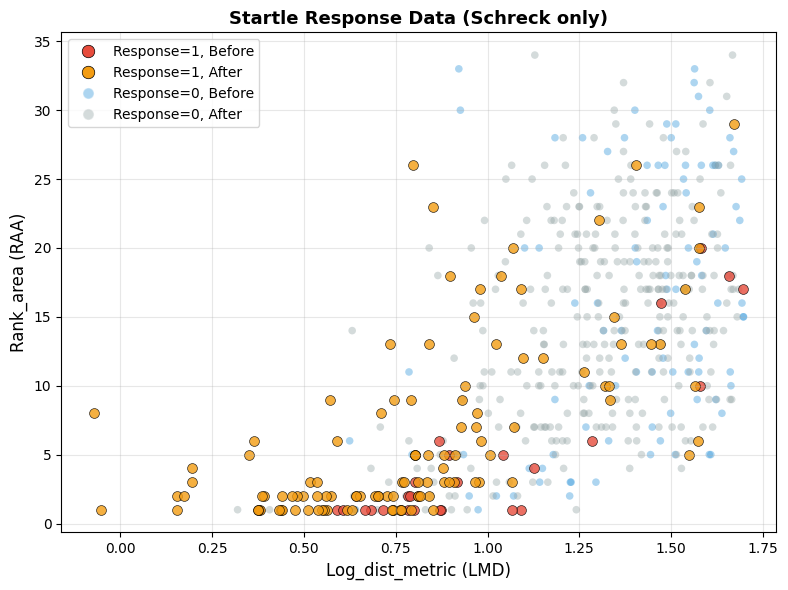

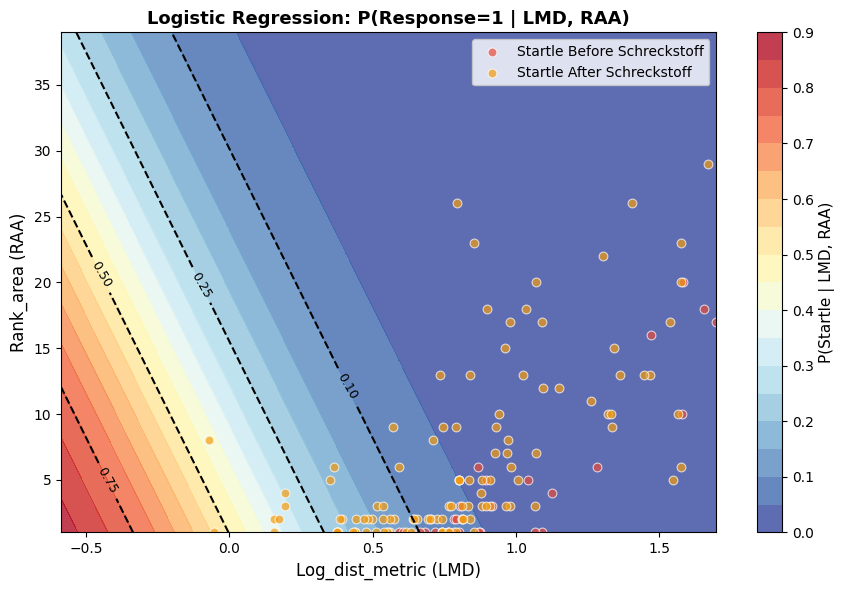


Model Coefficients (Schreck only):
  β₁ (Intercept):         0.064490
  β₂ (Log_dist_metric):  -3.297823
  β₃ (Rank_area):        -0.075034

Model equation:
  P(s_i | s_j) = 1 / (1 + exp(-β₁ - β₂·LMD - β₃·RAA))


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Use the Schreck-only dataset (the selected model)
df_plot = df_schreck.copy()

# ============================================================================
# PLOT 1: Scatter plot of the data
# ============================================================================

# Separate Response=1 (rare) and Response=0 (common)
df_response1 = df_plot[df_plot["Response"] == 1]
df_response0 = df_plot[df_plot["Response"] == 0]

# Sample Response=0 to roughly 3x the Response=1 count for better visualization
n_response1 = len(df_response1)
n_sample0 = min(len(df_response0), n_response1 * 3)
df_response0_sample = df_response0.sample(n=n_sample0, random_state=42)

# Combine for plotting
df_viz = pd.concat([df_response1, df_response0_sample])

print(
    f"Plotting {len(df_response1)} Response=1 cases and {len(df_response0_sample)} Response=0 cases"
)
print(f"  (out of {len(df_response0)} total Response=0 cases)")

# Define four distinct colors for the four categories
colors = {
    (0, "Before"): "#3498db",  # Blue
    (0, "After"): "#95a5a6",  # Gray
    (1, "Before"): "#e74c3c",  # Red
    (1, "After"): "#f39c12",  # Orange
}

fig1, ax1 = plt.subplots(figsize=(8, 6))

# Plot all four combinations with unique colors
for response in [0, 1]:
    for when in ["Before", "After"]:
        subset = df_viz[(df_viz["Response"] == response) & (df_viz["When"] == when)]

        color = colors[(response, when)]
        alpha = 0.8 if response == 1 else 0.4
        size = 50 if response == 1 else 30

        ax1.scatter(
            subset["Log_dist_metric"],
            subset["Rank_area"],
            c=color,
            marker="o",
            s=size,
            alpha=alpha,
            edgecolors="black" if response == 1 else "none",
            linewidths=0.5 if response == 1 else 0,
            label=f"Response={response}, When={when}",
        )

ax1.set_xlabel("Log_dist_metric (LMD)", fontsize=12)
ax1.set_ylabel("Rank_area (RAA)", fontsize=12)
ax1.set_title("Startle Response Data (Schreck only)", fontsize=13, fontweight="bold")
ax1.grid(True, alpha=0.3)

# Legend
legend_elements = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor=colors[(1, "Before")],
        markersize=9,
        label="Response=1, Before",
        markeredgecolor="black",
        markeredgewidth=0.5,
    ),
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor=colors[(1, "After")],
        markersize=9,
        label="Response=1, After",
        markeredgecolor="black",
        markeredgewidth=0.5,
    ),
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor=colors[(0, "Before")],
        markersize=8,
        label="Response=0, Before",
        alpha=0.4,
    ),
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor=colors[(0, "After")],
        markersize=8,
        label="Response=0, After",
        alpha=0.4,
    ),
]
ax1.legend(handles=legend_elements, loc="best")

plt.tight_layout()
plt.show()

# ============================================================================
# PLOT 2: Regression model probability surface
# ============================================================================

# Create a mesh grid over the feature space
log_dist_range = np.linspace(
    df_plot["Log_dist_metric"].min(), df_plot["Log_dist_metric"].max(), 100
)
rank_area_range = np.linspace(
    df_plot["Rank_area"].min(), df_plot["Rank_area"].max(), 100
)
log_dist_mesh, rank_area_mesh = np.meshgrid(log_dist_range, rank_area_range)

# Get the fitted coefficients from result2 (Schreck only)
beta_1 = result2.params["const"]
beta_2 = result2.params["Log_dist_metric"]
beta_3 = result2.params["Rank_area"]

# Calculate probability surface: P = 1 / (1 + exp(-beta_1 - beta_2*LMD - beta_3*RAA))
logit = beta_1 + beta_2 * log_dist_mesh + beta_3 * rank_area_mesh
prob_mesh = 1 / (1 + np.exp(-logit))

fig2, ax2 = plt.subplots(figsize=(9, 6))

# Create contour plot
contour = ax2.contourf(
    log_dist_mesh, rank_area_mesh, prob_mesh, levels=20, cmap="RdYlBu_r", alpha=0.8
)
contour_lines = ax2.contour(
    log_dist_mesh,
    rank_area_mesh,
    prob_mesh,
    levels=[0.1, 0.25, 0.5, 0.75, 0.9],
    colors="black",
    linewidths=1.5,
    linestyles="--",
)
ax2.clabel(contour_lines, inline=True, fontsize=9, fmt="%.2f")

# Overlay actual Response=1 data points
response1_before = df_response1[df_response1["When"] == "Before"]
response1_after = df_response1[df_response1["When"] == "After"]
ax2.scatter(
    response1_before["Log_dist_metric"],
    response1_before["Rank_area"],
    c=colors[(1, "Before")],
    marker="o",
    s=40,
    alpha=0.7,
    edgecolors="white",
    linewidths=0.8,
    label="Startle Before Schreckstoff",
)
ax2.scatter(
    response1_after["Log_dist_metric"],
    response1_after["Rank_area"],
    c=colors[(1, "After")],
    marker="o",
    s=40,
    alpha=0.7,
    edgecolors="white",
    linewidths=0.8,
    label="Startle After Schreckstoff",
)

ax2.set_xlabel("Log_dist_metric (LMD)", fontsize=12)
ax2.set_ylabel("Rank_area (RAA)", fontsize=12)
ax2.set_title(
    "Logistic Regression: P(Response=1 | LMD, RAA)", fontsize=13, fontweight="bold"
)
ax2.legend(loc="best")

# Add colorbar
cbar = plt.colorbar(contour, ax=ax2)
cbar.set_label("P(Startle | LMD, RAA)", fontsize=11)

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("Model Coefficients (Schreck only):")
print("=" * 80)
print(f"  β₁ (Intercept):       {beta_1:>10.6f}")
print(f"  β₂ (Log_dist_metric): {beta_2:>10.6f}")
print(f"  β₃ (Rank_area):       {beta_3:>10.6f}")
print("\nModel equation:")
print("  P(s_i | s_j) = 1 / (1 + exp(-β₁ - β₂·LMD - β₃·RAA))")